### Initialization

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import networkx
import matplotlib.pyplot as plt

In [0]:
dtype = torch.cuda.FloatTensor
dtype_l = torch.cuda.LongTensor

### Data generator

In [31]:
class dataGenerator:
    def __init__(self):
        self.NUM_SAMPLES_train = int(10e6)
        self.NUM_SAMPLES_test = int(10e4)
        self.data_train = []
        self.data_test = []
        self.J = 3
        self.N = 50
        self.edge_density = 0.2
        self.noise = 0.03
        
    def ErdosRenyi(self, p, N):
        G = networkx.erdos_renyi_graph(N, p)
        W = networkx.adjacency_matrix(G).todense().astype(float)
        W = np.array(W)
        return W
      
    def compute_operators(self, W):
        N = W.shape[0]
        # OP = operators: {Id, W, W^2, ..., W^{J-1}, D, U}
        deg = W.sum(1)
        D = np.diag(deg)
        W_pow = W.copy()
        OP = np.zeros([N, N, self.J + 2])
        OP[:, :, 0] = np.eye(N)
        for j in range(self.J):
            OP[:, :, j + 1] = W_pow.copy()
            W_pow = np.minimum(np.dot(W_pow, W_pow), np.ones(W_pow.shape))
        OP[:, :, self.J] = D
        OP[:, :, self.J + 1] = np.ones((N, N)) * (1.0 / float(N))
        x = np.reshape(deg, (N, 1))
        return OP, x
        
    def compute_sample(self):
        sample = {}
        W = self.ErdosRenyi(self.edge_density,self.N)
        # noise model from [arxiv 1602.04181], eq. (3.10)
        pe1 = self.noise
        pe2 = (self.edge_density * self.noise) / (1.0 - self.edge_density)
        noise1 = self.ErdosRenyi(pe1, self.N)
        noise2 = self.ErdosRenyi(pe2, self.N)
        noisey_W = W * (1 - noise1) + (1 - W) * noise2
        sample['OP'], sample['x'] = self.compute_operators(W)
        sample['noisey_OP'], sample['noisey_x'] = self.compute_operators(noisey_W)
        return sample
    
    def create_train_dataset(self):
        self.data_train = []
        for _ in range(self.NUM_SAMPLES_train):
            sample = self.compute_sample()
            self.data_train.append(sample)
            
    def create_test_dataset(self):
        self.data_test = []
        for _ in range(self.NUM_SAMPLES_test):
            sample = self.compute_sample()
            self.data_test.append(sample)
            
    def sample_batch(self, BATCH_SIZE, is_training=True, cuda=True, volatile=False):
        if is_training:
            data = self.data_train
        else:
            data = self.data_test
        OP_size = data[0]['OP'].shape
        x_size = data[0]['x'].shape
        
        OP = torch.zeros(OP_size).expand(BATCH_SIZE, *OP_size)
        x = torch.zeros(x_size).expand(BATCH_SIZE, *x_size)
        noisey_OP = torch.zeros(OP_size).expand(BATCH_SIZE, *OP_size)
        noisey_x = torch.zeros(x_size).expand(BATCH_SIZE, *x_size)
        
        for i in range(BATCH_SIZE):
            if is_training:
                ind = np.random.randint(0, len(data))
            else:
                ind = i
            OP[i] = torch.from_numpy(data[ind]['OP'])
            x[i] = torch.from_numpy(data[ind]['x'])
            noisey_OP[i] = torch.from_numpy(data[ind]['noisey_OP'])
            noisey_x[i] = torch.from_numpy(data[ind]['noisey_x'])
            
        OP = Variable(OP, volatile=volatile)
        x = Variable(x, volatile=volatile)
        noisey_OP = Variable(noisey_OP, volatile=volatile)
        noisey_x = Variable(noisey_x, volatile=volatile)
        
        if cuda:
            return [OP.cuda(), x.cuda()], [noisey_OP.cuda(), noisey_x.cuda()]
        else:
            return [OP, x], [noisey_OP, noisey_x]
          
# Test

generator = dataGenerator()
generator.NUM_SAMPLES_train = 100
generator.NUM_SAMPLES_test = 100
generator.N = 50
J = 5
generator.J = J-2
generator.create_train_dataset()
generator.create_test_dataset()
G1, G2 = generator.sample_batch(32)
print(G1[0].size())
print(G1[1][0].data.cpu().numpy())
G1 = G1[0][0, :, :, 1]
G2 = G2[0][0, :, :, 1]
print(G1, G1.size())
print(G2, G2.size())

# Test: OK

torch.Size([32, 50, 50, 5])
[[11.]
 [ 9.]
 [ 8.]
 [13.]
 [10.]
 [17.]
 [12.]
 [10.]
 [ 7.]
 [ 8.]
 [ 8.]
 [ 6.]
 [ 7.]
 [10.]
 [13.]
 [13.]
 [12.]
 [ 6.]
 [11.]
 [ 7.]
 [ 8.]
 [ 8.]
 [ 9.]
 [12.]
 [ 8.]
 [ 8.]
 [ 6.]
 [ 8.]
 [15.]
 [ 9.]
 [13.]
 [ 9.]
 [ 9.]
 [ 5.]
 [10.]
 [13.]
 [ 9.]
 [ 9.]
 [ 8.]
 [ 8.]
 [11.]
 [ 7.]
 [ 4.]
 [ 6.]
 [ 7.]
 [ 4.]
 [14.]
 [ 6.]
 [10.]
 [11.]]
Variable containing:
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
    0     1     0  ...      0     1     0
[torch.cuda.FloatTensor of size 50x50 (GPU 0)]
 torch.Size([50, 50])
Variable containing:
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      0     0     0
    0 

### GNN Model

In [32]:
def gmul(input):
    W, x = input
    # x is a tensor of size (bs, N, num_features)
    # W is a tensor of size (bs, N, N, J)
    N = W.size()[-2]
    W = W.split(1, 3) # W is a list of J tensors of size (bs, N, N, 1)
    W = torch.cat(W, 1).squeeze(3) # W is now a tensor of size (bs, J*N, N)
    output = torch.bmm(W, x) # matrix multiplication (J*N,N) x (N,num_features): output has size (bs, J*N, num_features)
    output = output.split(N, 1) # output is a list of J tensors of size (bs, N, num_features)
    output = torch.cat(output, 2)
    # output has size (bs, N, J*num_features)
    return output

class Gconv(nn.Module):
    def __init__(self, feature_maps, J):
        super(Gconv, self).__init__()
        self.num_inputs = J*feature_maps[0] # size of the input
        self.num_outputs = feature_maps[1] # size of the output
        self.fc1 = nn.Linear(self.num_inputs, self.num_outputs // 2)
        self.fc2 = nn.Linear(self.num_inputs, self.num_outputs // 2)
        self.bn = nn.BatchNorm1d(self.num_outputs)

    def forward(self, input):
        W = input[0]
        x = gmul(input) # x has size (bs, N, num_inputs)
        x_size = x.size()
        x = x.contiguous() # makes sure that x is stored in a contiguous chunk of memory
        x = x.view(-1, self.num_inputs)
        x1 = F.relu(self.fc1(x)) # x_1 has size (bs*N, num_outputs // 2)
        x2 = self.fc2(x) # x_2 has size (bs*N, num_outputs // 2)
        x = torch.cat((x1, x2), 1) # x has size (bs*N, num_outputs)
        x = self.bn(x)
        x = x.view(*x_size[:-1], self.num_outputs) # x has size (bs, N, num_outputs)
        return W, x
      
class Gconv_last(nn.Module):
    def __init__(self, feature_maps, J):
        super(Gconv_last, self).__init__()
        self.num_inputs = J*feature_maps[0] # size of the input
        self.num_outputs = feature_maps[1] # size of the output
        self.fc = nn.Linear(self.num_inputs, self.num_outputs) # the only difference is that there is no activations layer

    def forward(self, input):
        W = input[0]
        x = gmul(input) # out has size (bs, N, num_inputs)
        x_size = x.size()
        x = x.contiguous()
        x = x.view(x_size[0]*x_size[1], -1) # x has size (bs*N, num_inputs)
        x = self.fc(x) # x has size (bs*N, num_outputs)
        x = x.view(*x_size[:-1], self.num_outputs) # x has size (bs, N, num_outputs)
        return W, x

class GNN(nn.Module):
    def __init__(self, num_features, num_layers, J):
        super(GNN, self).__init__()
        self.num_features = num_features
        self.num_layers = num_layers
        self.featuremap_first = [1, num_features]
        self.featuremap = [num_features, num_features]
        self.layer0 = Gconv(self.featuremap_first, J)
        for i in range(num_layers):
            module = Gconv(self.featuremap, J)
            self.add_module('layer{}'.format(i + 1), module)
        self.layerlast = Gconv_last(self.featuremap, J)

    def forward(self, input):
        cur = self.layer0(input)
        for i in range(self.num_layers):
            cur = self._modules['layer{}'.format(i+1)](cur)
        out = self.layerlast(cur)
        return out[1]
      
class Siamese_GNN(nn.Module):
    def __init__(self, num_features, num_layers, J):
        super(Siamese_GNN, self).__init__()
        self.gnn = GNN(num_features, num_layers, J)
        
    def forward(self, G1, G2):
        emb1 = self.gnn(G1)
        emb2 = self.gnn(G2)
        # emb_ is a tensor of size (bs, N, num_features)
        out = torch.bmm(emb1, emb2.permute(0, 2, 1))
        # out is a tensor of size (bs, N, N)
        return out
      
# Test

num_features = 10
num_layers = 5
siamese_gnn = Siamese_GNN(num_features, num_layers, J).type(dtype)
G1, G2 = generator.sample_batch(32)
out = siamese_gnn(G1, G2)
print(out.size())

# Test: OK

torch.Size([32, 50, 50])


### Loss function

In [0]:
base_loss = nn.CrossEntropyLoss()

def compute_loss(pred, labels):
    # pred has size (bs, N, N)
    # labels has size (bs,N)
    pred = pred.view(-1, pred.size()[-1])
    labels = labels.view(-1)
    return base_loss(pred, labels)

### Optimizer

In [0]:
def get_optimizer(model):
    optimizer = optim.Adam(model.type(dtype).parameters(), lr=1e-3)
    return optimizer

### Logger

In [0]:
def compute_recovery_rate(pred, labels):
    pred = pred.max(2)[1] # argmax
    error = 1 - torch.eq(pred, labels).type(dtype)
    frob_norm = error.mean(1)
    accuracy = 1 - frob_norm
    accuracy = accuracy.mean(0).squeeze()
    return accuracy.data.cpu().numpy()[0]

class make_logger(object):
    def __init__(self):
        self.loss_train = []
        self.loss_test = []
        self.accuracy_train = []
        self.accuracy_test = []
        self.args = {}

    def add_train_loss(self, loss):
        self.loss_train.append(loss.data.cpu().numpy())

    def add_test_loss(self, loss):
        self.loss_test.append(loss)

    def add_train_accuracy(self, pred, labels):
        accuracy = compute_recovery_rate(pred, labels)
        self.accuracy_train.append(accuracy)

    def add_test_accuracy(self, pred, labels):
        accuracy = compute_recovery_rate(pred, labels)
        self.accuracy_test.append(accuracy)

    def plot_train_loss(self):
        plt.figure(0)
        plt.clf()
        iters = range(len(self.loss_train))
        plt.semilogy(iters, self.loss_train, 'b')
        plt.xlabel('iterations')
        plt.ylabel('Cross Entropy Loss')
        plt.title('Training Loss: p={}, p_e={}'.format(self.args['edge density'], self.args['noise']))

    def plot_train_accuracy(self):
        plt.figure(1)
        plt.clf()
        iters = range(len(self.accuracy_train))
        plt.plot(iters, self.accuracy_train, 'b')
        plt.xlabel('iterations')
        plt.ylabel('Accuracy')
        plt.title('Training Accuracy: p={}, p_e={}'.format(self.args['edge density'], self.args['noise']))

### Trainer

Dataset created
Iter: 0, Loss: 17.55
Iter: 100, Loss: 2.431
Iter: 200, Loss: 1.681
Iter: 300, Loss: 1.416
Iter: 400, Loss: 1.386
Iter: 500, Loss: 0.7828
Iter: 600, Loss: 1.229
Iter: 700, Loss: 1.759
Iter: 800, Loss: 1.442
Iter: 900, Loss: 1.166
Iter: 1000, Loss: 0.766
Iter: 1100, Loss: 2.325
Iter: 1200, Loss: 0.9192
Iter: 1300, Loss: 0.6507
Iter: 1400, Loss: 1.066
Iter: 1500, Loss: 1.211
Iter: 1600, Loss: 0.5415
Iter: 1700, Loss: 0.5329
Iter: 1800, Loss: 0.5926
Iter: 1900, Loss: 0.6304
Optimization finished.


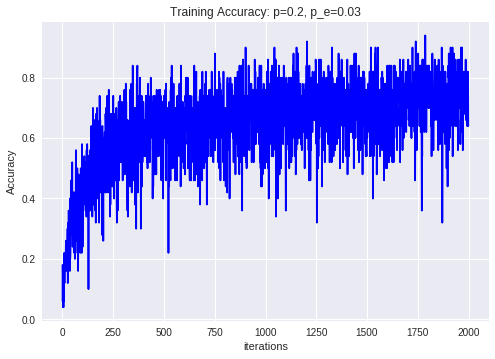

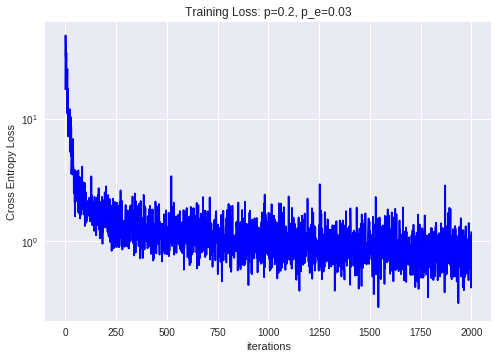

In [48]:
def train(model, generator, logger, iterations=60000, batch_size=32, clip_grad_norm=40.0, print_freq=100):
    # model should be a siamese_gnn
    # generator is the data_generator
    labels = Variable(torch.arange(0, generator.N).unsqueeze(0).expand(batch_size,generator.N)).type(dtype_l)
    # labels: [1,...,N] -> [[1,...N]] -> [[1,...N],...[1,...N]] of shape [batch_size,N]
    # the labels are these since the embedding the GNN should reproduce are identities
    optimizer = get_optimizer(model)
    for iter_count in range(iterations):
        input = generator.sample_batch(batch_size)
        pred = model(*input)
        loss = compute_loss(pred, labels)
        model.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm(model.parameters(), clip_grad_norm)
        optimizer.step()
        logger.add_train_loss(loss)
        logger.add_train_accuracy(pred, labels)
        if iter_count % print_freq == 0:
            print('Iter: {}, Loss: {:.4}'.format(iter_count,loss.data[0]))
    logger.plot_train_accuracy()
    logger.plot_train_loss()
    print('Optimization finished.')
    
# Test

args = {'edge density' : 0.2, 'noise' : 0.03}
logger = make_logger()
logger.args = args
generator = dataGenerator()
generator.edge_density = args['edge density']
generator.noise = args['noise']
generator.NUM_SAMPLES_train = 1000
generator.N = 50
J = 5
generator.J = J-2
generator.create_train_dataset()
print('Dataset created')
num_features = 10
num_layers = 5
siamese_gnn = Siamese_GNN(num_features, num_layers, J).type(dtype)
train(siamese_gnn, generator, logger, iterations=2000, batch_size=32)

# Test: OK

### Main


Dataset created
Iter: 0, Loss: 44.48
Iter: 100, Loss: 2.287
Iter: 200, Loss: 1.47
Iter: 300, Loss: 0.6676
Iter: 400, Loss: 1.207
Iter: 500, Loss: 0.7297
Iter: 600, Loss: 0.5492
Iter: 700, Loss: 0.4564
Iter: 800, Loss: 0.4118
Iter: 900, Loss: 0.5785
Iter: 1000, Loss: 0.3707
Iter: 1100, Loss: 0.374
Iter: 1200, Loss: 0.2546
Iter: 1300, Loss: 0.9306
Iter: 1400, Loss: 0.7193
Iter: 1500, Loss: 0.3222
Iter: 1600, Loss: 0.5813
Iter: 1700, Loss: 0.1967
Iter: 1800, Loss: 0.2381
Iter: 1900, Loss: 0.2151
Iter: 2000, Loss: 0.4984
Iter: 2100, Loss: 0.5293
Iter: 2200, Loss: 0.4694
Iter: 2300, Loss: 0.1577
Iter: 2400, Loss: 0.5804
Iter: 2500, Loss: 0.6169
Iter: 2600, Loss: 0.795
Iter: 2700, Loss: 0.3436
Iter: 2800, Loss: 0.6498
Iter: 2900, Loss: 0.1477
Iter: 3000, Loss: 0.1842
Iter: 3100, Loss: 0.4263
Iter: 3200, Loss: 0.2466
Iter: 3300, Loss: 0.1791
Iter: 3400, Loss: 0.2184
Iter: 3500, Loss: 0.1891
Iter: 3600, Loss: 0.4604
Iter: 3700, Loss: 0.4658
Iter: 3800, Loss: 0.4793
Iter: 3900, Loss: 0.1567
Ite

Iter: 8900, Loss: 0.1353
Iter: 9000, Loss: 0.391
Iter: 9100, Loss: 0.08965
Iter: 9200, Loss: 0.1573
Iter: 9300, Loss: 0.3656
Iter: 9400, Loss: 0.198
Iter: 9500, Loss: 0.1751
Iter: 9600, Loss: 0.1776
Iter: 9700, Loss: 0.09397
Iter: 9800, Loss: 0.6355
Iter: 9900, Loss: 0.1542
Iter: 10000, Loss: 0.08972
Iter: 10100, Loss: 0.393
Iter: 10200, Loss: 0.05001
Iter: 10300, Loss: 0.2554
Iter: 10400, Loss: 0.2248
Iter: 10500, Loss: 0.2262
Iter: 10600, Loss: 0.1863
Iter: 10700, Loss: 0.4691
Iter: 10800, Loss: 0.2893
Iter: 10900, Loss: 0.2424
Iter: 11000, Loss: 0.1194
Iter: 11100, Loss: 0.2633
Iter: 11200, Loss: 0.3939
Iter: 11300, Loss: 0.197
Iter: 11400, Loss: 0.3767
Iter: 11500, Loss: 0.3255
Iter: 11600, Loss: 0.09062
Iter: 11700, Loss: 0.1281
Iter: 11800, Loss: 0.8229
Iter: 11900, Loss: 0.533
Iter: 12000, Loss: 0.3036
Iter: 12100, Loss: 0.02609
Iter: 12200, Loss: 0.1515
Iter: 12300, Loss: 0.09748
Iter: 12400, Loss: 0.3646
Iter: 12500, Loss: 0.5051
Iter: 12600, Loss: 0.4096
Iter: 12700, Loss: 0.

Iter: 17600, Loss: 0.369
Iter: 17700, Loss: 0.05253
Iter: 17800, Loss: 0.3325
Iter: 17900, Loss: 0.1439
Iter: 18000, Loss: 0.1364
Iter: 18100, Loss: 0.7259
Iter: 18200, Loss: 0.09047
Iter: 18300, Loss: 0.4228
Iter: 18400, Loss: 0.07306
Iter: 18500, Loss: 0.252
Iter: 18600, Loss: 0.1262
Iter: 18700, Loss: 0.4422
Iter: 18800, Loss: 0.1167
Iter: 18900, Loss: 0.1608
Iter: 19000, Loss: 0.3066
Iter: 19100, Loss: 0.0664
Iter: 19200, Loss: 0.06361
Iter: 19300, Loss: 0.919
Iter: 19400, Loss: 0.07751
Iter: 19500, Loss: 0.1669
Iter: 19600, Loss: 0.1028
Iter: 19700, Loss: 0.104
Iter: 19800, Loss: 0.1945
Iter: 19900, Loss: 0.04975
Iter: 20000, Loss: 0.6071
Iter: 20100, Loss: 0.2537
Iter: 20200, Loss: 0.1029
Iter: 20300, Loss: 0.3938
Iter: 20400, Loss: 0.06186
Iter: 20500, Loss: 0.1172
Iter: 20600, Loss: 0.05241
Iter: 20700, Loss: 0.1486
Iter: 20800, Loss: 0.2345
Iter: 20900, Loss: 0.1172
Iter: 21000, Loss: 0.06684
Iter: 21100, Loss: 0.2426
Iter: 21200, Loss: 0.04727
Iter: 21300, Loss: 0.1104
Iter: 

Iter: 26300, Loss: 0.4413
Iter: 26400, Loss: 0.3208
Iter: 26500, Loss: 0.3581
Iter: 26600, Loss: 0.1324
Iter: 26700, Loss: 0.3464
Iter: 26800, Loss: 0.3222
Iter: 26900, Loss: 0.1682
Iter: 27000, Loss: 0.4376
Iter: 27100, Loss: 0.1401
Iter: 27200, Loss: 0.08647
Iter: 27300, Loss: 0.06825
Iter: 27400, Loss: 0.08394
Iter: 27500, Loss: 0.2406
Iter: 27600, Loss: 0.1415
Iter: 27700, Loss: 0.2465
Iter: 27800, Loss: 0.05182
Iter: 27900, Loss: 0.3206
Iter: 28000, Loss: 0.192
Iter: 28100, Loss: 0.4097
Iter: 28200, Loss: 0.1037
Iter: 28300, Loss: 0.2917
Iter: 28400, Loss: 0.3732
Iter: 28500, Loss: 0.2812
Iter: 28600, Loss: 0.03336
Iter: 28700, Loss: 0.05894
Iter: 28800, Loss: 0.1755
Iter: 28900, Loss: 0.152
Iter: 29000, Loss: 0.2334
Iter: 29100, Loss: 0.0523
Iter: 29200, Loss: 0.3172
Iter: 29300, Loss: 0.2943
Iter: 29400, Loss: 0.1429
Iter: 29500, Loss: 0.1237
Iter: 29600, Loss: 0.1356
Iter: 29700, Loss: 0.122
Iter: 29800, Loss: 0.08395
Iter: 29900, Loss: 0.3217
Iter: 30000, Loss: 0.4959
Iter: 30

Iter: 34900, Loss: 0.3048
Iter: 35000, Loss: 0.3746
Iter: 35100, Loss: 0.1383
Iter: 35200, Loss: 0.03955
Iter: 35300, Loss: 0.07981
Iter: 35400, Loss: 0.2332
Iter: 35500, Loss: 0.07435
Iter: 35600, Loss: 0.2922
Iter: 35700, Loss: 0.07935
Iter: 35800, Loss: 0.2082
Iter: 35900, Loss: 0.2234
Iter: 36000, Loss: 0.288
Iter: 36100, Loss: 0.2123
Iter: 36200, Loss: 0.4399
Iter: 36300, Loss: 0.1572
Iter: 36400, Loss: 0.257
Iter: 36500, Loss: 0.1922
Iter: 36600, Loss: 0.06815
Iter: 36700, Loss: 0.1202
Iter: 36800, Loss: 0.2355
Iter: 36900, Loss: 0.04541
Iter: 37000, Loss: 0.07732
Iter: 37100, Loss: 0.1531
Iter: 37200, Loss: 0.1162
Iter: 37300, Loss: 0.2157
Iter: 37400, Loss: 0.1882
Iter: 37500, Loss: 0.3596
Iter: 37600, Loss: 0.049
Iter: 37700, Loss: 0.1588
Iter: 37800, Loss: 0.1601
Iter: 37900, Loss: 0.6012
Iter: 38000, Loss: 0.2284
Iter: 38100, Loss: 0.1521
Iter: 38200, Loss: 0.1186
Iter: 38300, Loss: 0.07796
Iter: 38400, Loss: 0.1591
Iter: 38500, Loss: 0.2722
Iter: 38600, Loss: 0.5886
Iter: 3

Iter: 43500, Loss: 0.1108
Iter: 43600, Loss: 0.4195
Iter: 43700, Loss: 0.02325
Iter: 43800, Loss: 0.1731
Iter: 43900, Loss: 0.1861
Iter: 44000, Loss: 0.02189
Iter: 44100, Loss: 0.1583
Iter: 44200, Loss: 0.09848
Iter: 44300, Loss: 0.1777
Iter: 44400, Loss: 0.06141
Iter: 44500, Loss: 0.2239
Iter: 44600, Loss: 0.06355
Iter: 44700, Loss: 0.234
Iter: 44800, Loss: 0.1484
Iter: 44900, Loss: 0.1666
Iter: 45000, Loss: 0.1676
Iter: 45100, Loss: 0.6069
Iter: 45200, Loss: 0.2491
Iter: 45300, Loss: 0.07064
Iter: 45400, Loss: 0.2123
Iter: 45500, Loss: 0.3764
Iter: 45600, Loss: 0.1918
Iter: 45700, Loss: 0.09783
Iter: 45800, Loss: 0.1137
Iter: 45900, Loss: 0.04154
Iter: 46000, Loss: 0.05115
Iter: 46100, Loss: 0.01835
Iter: 46200, Loss: 0.1304
Iter: 46300, Loss: 0.4866
Iter: 46400, Loss: 0.3379
Iter: 46500, Loss: 0.1721
Iter: 46600, Loss: 0.2228
Iter: 46700, Loss: 0.311
Iter: 46800, Loss: 0.2885
Iter: 46900, Loss: 0.03868
Iter: 47000, Loss: 0.1918
Iter: 47100, Loss: 0.0125
Iter: 47200, Loss: 0.02378
It

Iter: 52100, Loss: 0.2538
Iter: 52200, Loss: 0.1114
Iter: 52300, Loss: 0.1003
Iter: 52400, Loss: 0.1187
Iter: 52500, Loss: 0.1471
Iter: 52600, Loss: 0.3036
Iter: 52700, Loss: 0.6827
Iter: 52800, Loss: 0.02515
Iter: 52900, Loss: 0.02715
Iter: 53000, Loss: 0.1419
Iter: 53100, Loss: 0.09202
Iter: 53200, Loss: 0.333
Iter: 53300, Loss: 0.2298
Iter: 53400, Loss: 0.08929
Iter: 53500, Loss: 0.0828
Iter: 53600, Loss: 0.2848
Iter: 53700, Loss: 0.1974
Iter: 53800, Loss: 0.1198
Iter: 53900, Loss: 0.1451
Iter: 54000, Loss: 0.3123
Iter: 54100, Loss: 0.2053
Iter: 54200, Loss: 0.288
Iter: 54300, Loss: 0.04651
Iter: 54400, Loss: 0.101
Iter: 54500, Loss: 0.1015
Iter: 54600, Loss: 0.5297
Iter: 54700, Loss: 0.1905
Iter: 54800, Loss: 0.3325
Iter: 54900, Loss: 0.1596
Iter: 55000, Loss: 0.1153
Iter: 55100, Loss: 0.3168
Iter: 55200, Loss: 0.1737
Iter: 55300, Loss: 0.2025
Iter: 55400, Loss: 0.04236
Iter: 55500, Loss: 0.03958
Iter: 55600, Loss: 0.236
Iter: 55700, Loss: 0.08587
Iter: 55800, Loss: 0.08454
Iter: 5

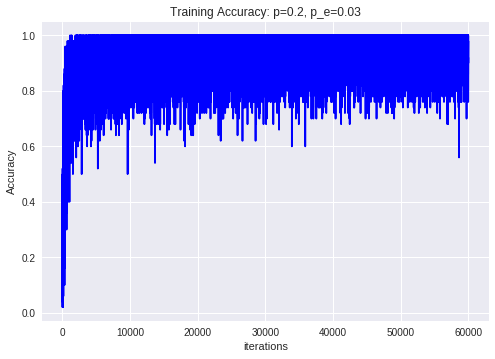

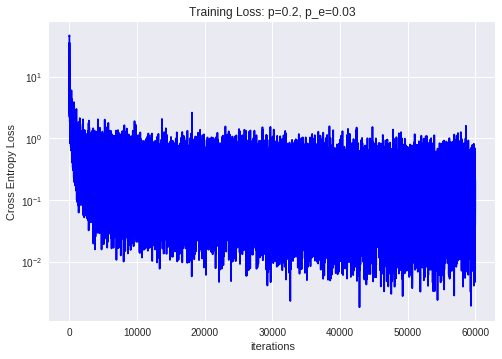

In [49]:
args = {'edge density' : 0.2, 'noise' : 0.03}
logger = make_logger()
logger.args = args
generator = dataGenerator()
generator.edge_density = args['edge density']
generator.noise = args['noise']
generator.NUM_SAMPLES_train = 20000
generator.N = 50
J = 6
generator.J = J-2
generator.create_train_dataset()
print('Dataset created')
num_features = 20
num_layers = 20
siamese_gnn = Siamese_GNN(num_features, num_layers, J).type(dtype)
train(siamese_gnn, generator, logger, iterations=60000, batch_size=32)